In [1]:
import torch
import os
import glob 
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchsummary import summary
from torch import nn
import cv2
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import requests
import albumentations as A
from src.dataset_2 import FilteredCocoDataset
from src.draw_bboxes import draw_bboxes
from src.multibox_loss import MultiBoxLoss
from sklearn.model_selection import train_test_split
import config
import json
import numpy as np
import random
import torchvision
from torchview import draw_graph
from math import sqrt
from src.bbox_converters import *
from tqdm import tqdm

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.13 (you have 1.4.9). Upgrade using: pip install --upgrade albumentations


## Configure

In [52]:
from src.config import * #CATEGORY, BATCH_SIZE, LR, EPOCHS, IMAGE_WIDTH, IMAGE_HEIGHT
print(CATEGORY, BATCH_SIZE, LR, EPOCHS, IMAGE_WIDTH, IMAGE_HEIGHT)

person 16 0.0003 25 300 300


In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'{DEVICE = }')

DEVICE = 'cuda'


In [4]:
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

## Filtered COCO dataset

In [5]:
images_folder = './dataset/val2017/val2017/'
annot_json = './dataset/annotations_trainval2017/annotations/instances_val2017.json'

In [6]:
transform = A.Compose([
    A.Resize(width=IMAGE_WIDTH, height=IMAGE_HEIGHT),
    #A.SmallestMaxSize(max_size = min(IMAGE_WIDTH, IMAGE_HEIGHT)),
    #A.RandomCrop(width=IMAGE_WIDTH, height=IMAGE_HEIGHT),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    #A.ColorJitter(hue=(-0.05,0.05))
    
], bbox_params=A.BboxParams(format='coco', label_fields=['class_labels']))

full_dataset = FilteredCocoDataset(CATEGORY, annot_json, images_folder, IMAGE_WIDTH, IMAGE_HEIGHT, transform)
print(full_dataset)

loading annotations into memory...
Done (t=0.38s)
creating index...
index created!
Dataset FilteredCocoDataset
    Number of datapoints: 2693
    Annotations JSON Path: ./dataset/annotations_trainval2017/annotations/instances_val2017.json
    Images filder location: ./dataset/val2017/val2017/



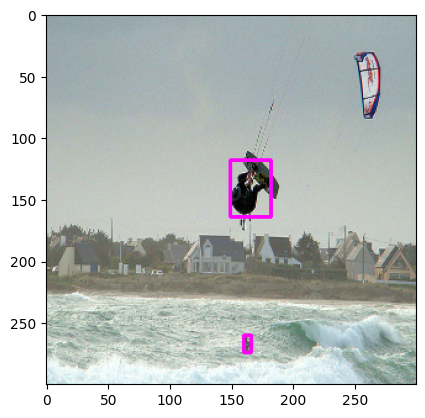

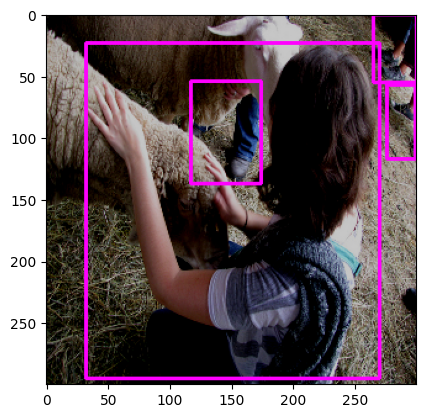

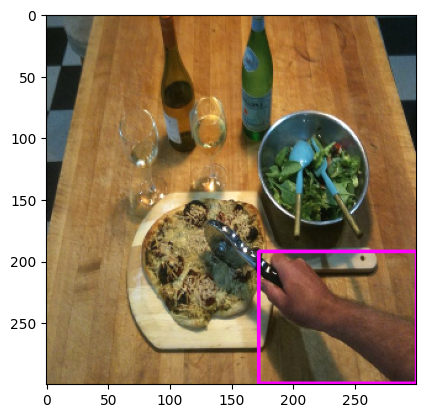

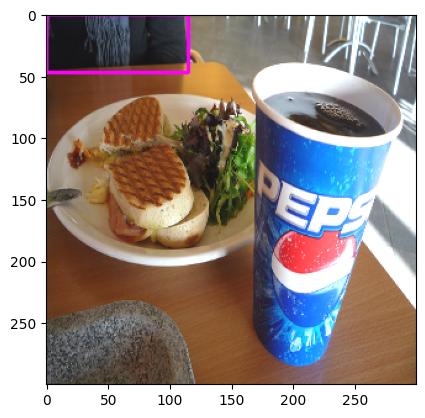

In [7]:
for idx in range(4):
    image, bboxes, labels = full_dataset[idx]
    plt.imshow(draw_bboxes(image.permute(1,2,0).numpy().astype('float'), np.array(bboxes)))
    plt.show()

## Dataloader

In [8]:
# https://github.com/amdegroot/ssd.pytorch/blob/master/data/__init__.py#L9
def detection_collate(batch):
    """Custom collate fn for dealing with batches of images that have a different
    number of associated object annotations (bounding boxes).

    Args:
        batch: (tuple) A tuple of tensor images and lists of bboxes and labels

    Return:
        A tuple containing:
            1) (tensor) batch of images stacked on their 0 dim
            2) (list of tensors) bboxes for a given image are stacked on 0 dim
            3) (list of tensors) labels for a given image are stacked on 0 dim
    """
    boxes = []
    labels = []
    imgs = []
    for sample in batch:
        imgs.append(sample[0])
        boxes.append(torch.FloatTensor(sample[1]))
        labels.append(torch.FloatTensor(sample[2]))
    return torch.stack(imgs, 0), boxes, labels

In [9]:
train_size = int(0.9 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

# train
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, collate_fn=detection_collate)

# test
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, collate_fn=detection_collate)
test_dataset.transforms = None

print('train_dataset images:', len(train_dataset))
print('test_dataset images:', len(test_dataset))
images, bboxes, labels = next(iter(train_loader))

train_dataset images: 2423
test_dataset images: 270


## Simple SSD model

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

SSD architecture description:

https://russianblogs.com/article/9042540283/

https://www.geeksforgeeks.org/how-single-shot-detector-ssd-works/


In [11]:
class ConvolutionBlock(nn.Module):
    def __init__(self, in_ch: int, out_ch: int, subblocks: int, downsample: bool):
        """
        Convolution block with residual connection

        Args:
            in_ch: input channels
            out_ch: output channels
            subblocks: amount of internal blocks of [Conv2d, BatchNorm, ReLU]
            downsample: if True - last convolution layer will downsample resolution by 2
        """
        super().__init__()

        self.blocks = nn.ModuleList()
        self.relu = nn.ReLU()
        stride = 2 if downsample else 1
        self.out_conv = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1)
        
        for i in range(subblocks):
            self.blocks.append(
                nn.Sequential(
                    nn.Conv2d(in_ch, in_ch, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(in_ch),
                    nn.ReLU()
                )
            )
            
    def forward(self, x):
        residual = x  
        for block in self.blocks:
            x = block(x)                
        x = x + residual
        x = self.out_conv(x)
        x = self.relu(x)
        return x


class SimpleSSD(nn.Module):
    def __init__(self, num_classes: int, device: str):
        """"
        Init network

        Args:
            num_classes: number of classes including background
        
        """
        super().__init__()
        
        self.device = device
        self.num_classes = num_classes 
        self.prior_boxes = self.create_prior_boxes()

        # ---------------------------------------------------------------------------------
        # Convolution layers
        # ---------------------------------------------------------------------------------
        # feature extraction layers
        self.features = nn.ModuleList([
            ConvolutionBlock(3, 64, 1, False),               # -> N, 64, 300, 300
            ConvolutionBlock(64, 128, 2, True),              # -> N, 128, 150, 150
            ConvolutionBlock(128, 256, 2, True)              # -> N, 256, 75, 75
        ])

        # feature extraction with per-layer prediction of class and localisation
        self.extras = nn.ModuleList([
            ConvolutionBlock(256, 512, 2, True),             # -> N, 512, 38, 38
            ConvolutionBlock(512, 1024, 2, True),            # -> N, 1024, 19, 19
            ConvolutionBlock(1024, 512, 2, True),            # -> N, 512, 10, 10
            ConvolutionBlock(512, 256, 2, True),             # -> N, 256, 5, 5
            ConvolutionBlock(256, 256, 2, True),             # -> N, 256, 3, 3
            nn.AvgPool2d(kernel_size=3, stride=1, padding=0) # -> N, 256, 1, 1
        ])

        
        # ---------------------------------------------------------------------------------
        # Localization and class prediction heads
        # ---------------------------------------------------------------------------------
        # localisation bounding boxes prediction
        k=3
        p=1
        self.loc = nn.ModuleList([
            nn.Conv2d(512,  4 * 4, kernel_size=k, padding=p),  # 4 default boxes, 5776 boxes total
            nn.Conv2d(1024, 6 * 4, kernel_size=k, padding=p),  # 6 default boxes, 2166 boxes total
            nn.Conv2d(512,  6 * 4, kernel_size=k, padding=p),  # 6 default boxes,  600 boxes total
            nn.Conv2d(256,  6 * 4, kernel_size=k, padding=p),  # 6 default boxes,  150 boxes total
            nn.Conv2d(256,  4 * 4, kernel_size=k, padding=p),  # 4 default boxes,   36 boxes total
            nn.Conv2d(256,  4 * 4, kernel_size=k, padding=p)   # 4 default boxes,    4 boxes total
        ])

        # class predictions
        self.conf = nn.ModuleList([
            nn.Conv2d(512,  4 * num_classes, kernel_size=k, padding=p),
            nn.Conv2d(1024, 6 * num_classes, kernel_size=k, padding=p),
            nn.Conv2d(512,  6 * num_classes, kernel_size=k, padding=p),
            nn.Conv2d(256,  6 * num_classes, kernel_size=k, padding=p),
            nn.Conv2d(256,  4 * num_classes, kernel_size=k, padding=p),
            nn.Conv2d(256,  4 * num_classes, kernel_size=k, padding=p)
        ]) 

    def forward(self, x):
        locs = list()
        confs = list()

        # features extraction
        for i, layer in enumerate(self.features):
            x = layer(x)
            
        # features extraction + locations and conf
        for i, layer in enumerate(self.extras):
            x = layer(x)
            locs.append(self.loc[i](x).permute(0, 2, 3, 1).contiguous())
            confs.append(self.conf[i](x).permute(0, 2, 3, 1).contiguous())  

        # Reshape and concatenate predictions
        locs = torch.cat([o.view(o.size(0), -1) for o in locs], 1)
        confs = torch.cat([o.view(o.size(0), -1) for o in confs], 1)

        locs = locs.view(locs.size(0), -1, 4)
        confs = confs.view(confs.size(0), -1, self.num_classes)
        
        return locs, confs


    # https://www.kaggle.com/code/sdeagggg/ssd300-with-pytorch
    def create_prior_boxes(self):
        """
        Create the 8732 prior (default) boxes for the SSD300, as defined in the paper.
        Return: 
            prior boxes in center-size coordinates, a tensor of dimensions (8732, 4)
        """
        fmap_dims = {'detector_1': 38,
                     'detector_2': 19,
                     'detector_3': 10,
                     'detector_4': 5,
                     'detector_5': 3,
                     'detector_6': 1}

        # calculate scales according paper
        '''
        smin=0.2
        smax=0.9
        m=6
        for k in range(1,m+1):
            sk =smin+(smax-smin)/(m-1)*(k-1)
            print(sk)
        '''

        obj_scales = {'detector_1': 0.2,
                      'detector_2': 0.34,
                      'detector_3': 0.48,
                      'detector_4': 0.62,
                      'detector_5': 0.76,
                      'detector_6': 0.9}

        aspect_ratios = {'detector_1': [1., 2., 0.5],
                         'detector_2': [1., 2., 3., 0.5, .333],
                         'detector_3': [1., 2., 3., 0.5, .333],
                         'detector_4': [1., 2., 3., 0.5, .333],
                         'detector_5': [1., 2., 0.5],
                         'detector_6': [1., 2., 0.5]}

        fmaps = list(fmap_dims.keys())

        prior_boxes = []

        for k, fmap in enumerate(fmaps):
            for i in range(fmap_dims[fmap]):
                for j in range(fmap_dims[fmap]):

                    # define center location of bbox in relative coordinates (0...1)
                    cx = (j + 0.5) / fmap_dims[fmap]
                    cy = (i + 0.5) / fmap_dims[fmap]

                    # 
                    for ratio in aspect_ratios[fmap]:
                        prior_boxes.append([cx, cy, obj_scales[fmap] * sqrt(ratio), obj_scales[fmap] / sqrt(ratio)])

                        # For an aspect ratio of 1, use an additional prior whose scale is the geometric mean of the
                        # scale of the current feature map and the scale of the next feature map
                        if ratio == 1.:
                            try:
                                additional_scale = sqrt(obj_scales[fmap] * obj_scales[fmaps[k + 1]])
                            # For the last feature map, there is no "next" feature map
                            except IndexError:
                                additional_scale = 1.
                            prior_boxes.append([cx, cy, additional_scale, additional_scale])

        prior_boxes = torch.FloatTensor(prior_boxes).to(self.device)  # (8732, 4)
        prior_boxes.clamp_(0, 1)  # (8732, 4)

        return prior_boxes

    def detect_objects(self, predicted_locs, predicted_scores, min_score, max_overlap, top_k):
        """
        Decipher the 8732 locations and class scores (output of ths SSD300) to detect objects.
        For each class, perform Non-Maximum Suppression (NMS) on boxes that are above a minimum threshold.
        :param predicted_locs: predicted locations/boxes w.r.t the 8732 prior boxes, a tensor of dimensions (N, 8732, 4)
        :param predicted_scores: class scores for each of the encoded locations/boxes, a tensor of dimensions (N, 8732, num_classes)
        :param min_score: minimum threshold for a box to be considered a match for a certain class
        :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed via NMS
        :param top_k: if there are a lot of resulting detection across all classes, keep only the top 'k'
        :return: detections (boxes, labels, and scores), lists of length batch_size
        """
        batch_size = predicted_locs.size(0)
        n_priors = self.prior_boxes.size(0)
#         print(n_priors)
        predicted_scores = F.softmax(predicted_scores, dim=2)  # (N, 8732, num_classes)

        # Lists to store final predicted boxes, labels, and scores for all images
        all_images_boxes = list()
        all_images_labels = list()
        all_images_scores = list()

        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        for i in range(batch_size):
            # Decode object coordinates from the form we regressed predicted boxes to
            decoded_locs = cxcy_to_xy(
                gcxgcy_to_cxcy(predicted_locs[i], self.prior_boxes))  # (8732, 4), these are fractional pt. coordinates

            # Lists to store boxes and scores for this image
            image_boxes = list()
            image_labels = list()
            image_scores = list()

            max_scores, best_label = predicted_scores[i].max(dim=1)  # (8732)

            # Check for each class
            for c in range(1, self.num_classes):
                # Keep only predicted boxes and scores where scores for this class are above the minimum score
                class_scores = predicted_scores[i][:, c]  # (8732)
                score_above_min_score = class_scores > min_score  # torch.uint8 (byte) tensor, for indexing
                n_above_min_score = score_above_min_score.sum().item()
                if n_above_min_score == 0:
                    continue
                class_scores = class_scores[score_above_min_score]  # (n_qualified), n_min_score <= 8732
                class_decoded_locs = decoded_locs[score_above_min_score]  # (n_qualified, 4)

                # Sort predicted boxes and scores by scores
                class_scores, sort_ind = class_scores.sort(dim=0, descending=True)  # (n_qualified), (n_min_score)
                class_decoded_locs = class_decoded_locs[sort_ind]  # (n_min_score, 4)

                # Find the overlap between predicted boxes
                overlap = find_jaccard_overlap(class_decoded_locs, class_decoded_locs)  # (n_qualified, n_min_score)

                # Non-Maximum Suppression (NMS)

                # A torch.uint8 (byte) tensor to keep track of which predicted boxes to suppress
                # 1 implies suppress, 0 implies don't suppress
                suppress = torch.zeros((n_above_min_score), dtype=torch.uint8).cuda()  # (n_qualified)

                # Consider each box in order of decreasing scores
                for box in range(class_decoded_locs.size(0)):
                    # If this box is already marked for suppression
                    if suppress[box] == 1:
                        continue

                    # Suppress boxes whose overlaps (with this box) are greater than maximum overlap
                    # Find such boxes and update suppress indices
                    suppress = torch.max(suppress, overlap[box] > max_overlap)
                    # The max operation retains previously suppressed boxes, like an 'OR' operation

                    # Don't suppress this box, even though it has an overlap of 1 with itself
                    suppress[box] = 0

                # Store only unsuppressed boxes for this class
                image_boxes.append(class_decoded_locs[1 - suppress])
                image_labels.append(torch.LongTensor((1 - suppress).sum().item() * [c]).cuda())
                image_scores.append(class_scores[1 - suppress])

            # If no object in any class is found, store a placeholder for 'background'
            if len(image_boxes) == 0:
                image_boxes.append(torch.FloatTensor([[0., 0., 1., 1.]]).cuda())
                image_labels.append(torch.LongTensor([0]).cuda())
                image_scores.append(torch.FloatTensor([0.]).cuda())

            # Concatenate into single tensors
            image_boxes = torch.cat(image_boxes, dim=0)  # (n_objects, 4)
            image_labels = torch.cat(image_labels, dim=0)  # (n_objects)
            image_scores = torch.cat(image_scores, dim=0)  # (n_objects)
            n_objects = image_scores.size(0)

            # Keep only the top k objects
            if n_objects > top_k:
                image_scores, sort_ind = image_scores.sort(dim=0, descending=True)
                image_scores = image_scores[:top_k]  # (top_k)
                image_boxes = image_boxes[sort_ind][:top_k]  # (top_k, 4)
                image_labels = image_labels[sort_ind][:top_k]  # (top_k)

            # Append to lists that store predicted boxes and scores for all images
            all_images_boxes.append(image_boxes)
            all_images_labels.append(image_labels)
            all_images_scores.append(image_scores)

        return all_images_boxes, all_images_labels, all_images_scores  # lists of length batch_size

def test():
    model = SimpleSSD(2, DEVICE).to(DEVICE)
    print(f'Trainable parameters: {count_parameters(model):,}')

    x = torch.randn((16, 3, IMAGE_HEIGHT, IMAGE_WIDTH)).to(DEVICE)
    locs, confs = model(x)
    print('-'*20)
    print('Delta locs shape:', locs.shape)
    print('Class confs shape:', confs.shape)
    print('prior_boxes.shape:', model.prior_boxes.shape)
    print('example prior_boxes[0]:', model.prior_boxes[0])
    print('-'*20)
    print('example locs[0,0] values:', locs[0,0].cpu().detach().numpy())
    print('example confs[0,0] values:', confs[0,0].cpu().detach().numpy())
    print('-'*20)
    
    #summary(model, x.shape[1:])
    
test()

Trainable parameters: 44,617,742
--------------------
Delta locs shape: torch.Size([16, 8732, 4])
Class confs shape: torch.Size([16, 8732, 2])
prior_boxes.shape: torch.Size([8732, 4])
example prior_boxes[0]: tensor([0.0132, 0.0132, 0.2000, 0.2000], device='cuda:0')
--------------------
example locs[0,0] values: [-0.03533273  0.08619582  0.14831288  0.06762167]
example confs[0,0] values: [-0.12341428 -0.13147883]
--------------------


In [12]:
# save model graph as image
model_graph = draw_graph(SimpleSSD(2, DEVICE), input_size=(1,3,IMAGE_HEIGHT, IMAGE_WIDTH), expand_nested=True)
model_graph.resize_graph(scale=1.0)
model_graph.visual_graph.render(format='png')
#model_graph.visual_graph

'model.gv.png'

## Train

In [13]:
model = SimpleSSD(2, DEVICE).to(DEVICE)

In [14]:
loss_fn = MultiBoxLoss(model.prior_boxes)

/home/ximader/miniconda3/envs/cv/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [16]:
if EPOCHS == 0:
    #Load:
    model = SimpleSSD(2, DEVICE).to(DEVICE)
    model.load_state_dict(torch.load('models/model.pth'))

In [17]:
for epoch in range(1, EPOCHS+1):
    model.train()
    train_loss = []
    
    for step, (img, boxes, labels) in enumerate(pbar := tqdm(train_loader)):

        img = img.to(DEVICE)
        boxes = [box.to(DEVICE) for box in boxes]  
        labels = [label.to(DEVICE) for label in labels]  

        pred_loc, pred_sco = model(img)
        try:
            loss = loss_fn(pred_loc, pred_sco, boxes, labels)
            
            # Back propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            train_loss.append(loss.item())

            descr = f"Train loss: {np.mean(train_loss):.4f}"
            pbar.set_description(descr)
        except:
            pass
    
    model.eval()
    valid_loss = []
    for step, (img, boxes, labels) in enumerate(tqdm(test_loader)):
        img = img.to(DEVICE)
        boxes = [box.to(DEVICE) for box in boxes]
        labels = [label.to(DEVICE) for label in labels]
        pred_loc, pred_sco = model(img)
        try:
            loss = loss_fn(pred_loc, pred_sco, boxes, labels)
            valid_loss.append(loss.item())
        except:
            pass
        
    print('epoch:', epoch, '/', EPOCHS,
            '\ttrain loss:', '{:.4f}'.format(np.mean(train_loss)),
            '\tvalid loss:', '{:.4f}'.format(np.mean(valid_loss)))
    
torch.save(model.state_dict(), os.path.join('models', 'model.pth'))

100%|███████████████████████████████████| 17/17 [00:03<00:00,  4.28it/s]


epoch: 1 / 25 	train loss: 3.8710 	valid loss: 3.4789


100%|███████████████████████████████████| 17/17 [00:04<00:00,  4.20it/s]


epoch: 2 / 25 	train loss: 3.4903 	valid loss: 3.4399


100%|███████████████████████████████████| 17/17 [00:04<00:00,  4.20it/s]


epoch: 3 / 25 	train loss: 3.4440 	valid loss: 3.4235


100%|███████████████████████████████████| 17/17 [00:04<00:00,  4.22it/s]


epoch: 4 / 25 	train loss: 3.4220 	valid loss: 3.4172


100%|███████████████████████████████████| 17/17 [00:04<00:00,  4.16it/s]


epoch: 5 / 25 	train loss: 3.4066 	valid loss: 3.4268


100%|███████████████████████████████████| 17/17 [00:04<00:00,  4.14it/s]


epoch: 6 / 25 	train loss: 3.3889 	valid loss: 3.4393


100%|███████████████████████████████████| 17/17 [00:03<00:00,  4.36it/s]


epoch: 7 / 25 	train loss: 3.3731 	valid loss: 3.3716


100%|███████████████████████████████████| 17/17 [00:04<00:00,  4.15it/s]


epoch: 8 / 25 	train loss: 3.3484 	valid loss: 3.3926


100%|███████████████████████████████████| 17/17 [00:03<00:00,  4.39it/s]


epoch: 9 / 25 	train loss: 3.3354 	valid loss: 3.3616


100%|███████████████████████████████████| 17/17 [00:04<00:00,  4.09it/s]


epoch: 10 / 25 	train loss: 3.3270 	valid loss: 3.3401


100%|███████████████████████████████████| 17/17 [00:03<00:00,  4.29it/s]


epoch: 11 / 25 	train loss: 3.3025 	valid loss: 3.3466


100%|███████████████████████████████████| 17/17 [00:03<00:00,  4.39it/s]


epoch: 12 / 25 	train loss: 3.2983 	valid loss: 3.3412


100%|███████████████████████████████████| 17/17 [00:04<00:00,  4.03it/s]


epoch: 13 / 25 	train loss: 3.2757 	valid loss: 3.2897


100%|███████████████████████████████████| 17/17 [00:04<00:00,  4.20it/s]


epoch: 14 / 25 	train loss: 3.2621 	valid loss: 3.2894


100%|███████████████████████████████████| 17/17 [00:04<00:00,  4.15it/s]


epoch: 15 / 25 	train loss: 3.2509 	valid loss: 3.3097


100%|███████████████████████████████████| 17/17 [00:04<00:00,  4.10it/s]


epoch: 16 / 25 	train loss: 3.2353 	valid loss: 3.3073


100%|███████████████████████████████████| 17/17 [00:04<00:00,  4.07it/s]


epoch: 17 / 25 	train loss: 3.2214 	valid loss: 3.2654


100%|███████████████████████████████████| 17/17 [00:03<00:00,  4.26it/s]


epoch: 18 / 25 	train loss: 3.2071 	valid loss: 3.2741


100%|███████████████████████████████████| 17/17 [00:03<00:00,  4.27it/s]


epoch: 19 / 25 	train loss: 3.2061 	valid loss: 3.2406


100%|███████████████████████████████████| 17/17 [00:04<00:00,  4.15it/s]


epoch: 20 / 25 	train loss: 3.1885 	valid loss: 3.2275


100%|███████████████████████████████████| 17/17 [00:03<00:00,  4.27it/s]


epoch: 21 / 25 	train loss: 3.1809 	valid loss: 3.2012


100%|███████████████████████████████████| 17/17 [00:04<00:00,  4.20it/s]


epoch: 22 / 25 	train loss: 3.1628 	valid loss: 3.2510


100%|███████████████████████████████████| 17/17 [00:04<00:00,  4.16it/s]


epoch: 23 / 25 	train loss: 3.1604 	valid loss: 3.2356


100%|███████████████████████████████████| 17/17 [00:04<00:00,  4.11it/s]


epoch: 24 / 25 	train loss: 3.1506 	valid loss: 3.2013


100%|███████████████████████████████████| 17/17 [00:03<00:00,  4.28it/s]


epoch: 25 / 25 	train loss: 3.1357 	valid loss: 3.2659


## Test (files from folder)

In [30]:
def detect(model, image, min_score=0.4, max_overlap=0.5, top_k=100):
    """ 
    Detect objects on single image 

    Args:
        model: Simple SSD mmodel
        orig_image: input image in numpy RGB format
        min_score: minimum confidence score to detect object
        max_overlap: max overlap to non-maximum supression
        top_k: maximum amount of bboxes

    Return:
        image: annotated image
        
    """

    # prepare input image
    if np.max(image)>1:
        image = image/255.
    
    image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))
    tensor = torch.tensor(image).permute(2,0,1).float().unsqueeze(0).to(DEVICE)

    # make predictions
    predicted_locs, predicted_scores = model(tensor)

    # detect bboxes ordered by confidence score
    det_boxes, det_labels, det_scores = model.detect_objects(
        predicted_locs, predicted_scores, min_score=min_score, max_overlap=max_overlap, top_k=top_k)

    # get detections for single image
    det_boxes = det_boxes[0].to('cpu').detach().numpy()
    det_labels = det_labels[0].to('cpu').detach().numpy()
    det_scores = det_scores[0].to('cpu').detach().numpy()

    # filter only objects
    for i in range(len(det_boxes)):
        if det_labels[i] != 0:
            image = draw_bboxes(image, [det_boxes[i]], [det_labels[i]], [det_scores[i]])

    return image
    
    

/tmp/ipykernel_94653/3767907929.py:266: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  image_boxes.append(class_decoded_locs[1 - suppress])
/tmp/ipykernel_94653/3767907929.py:268: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  image_scores.append(class_scores[1 - suppress])


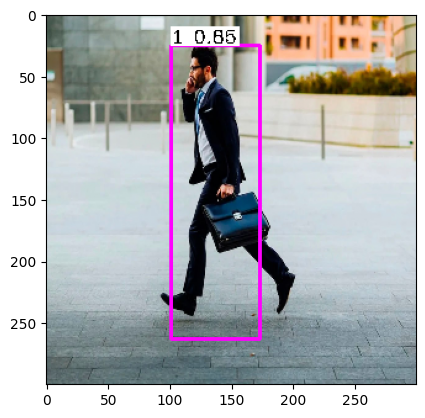

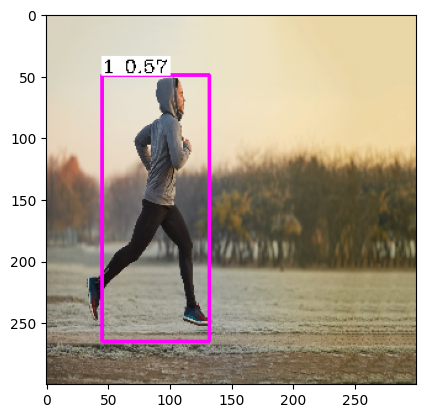

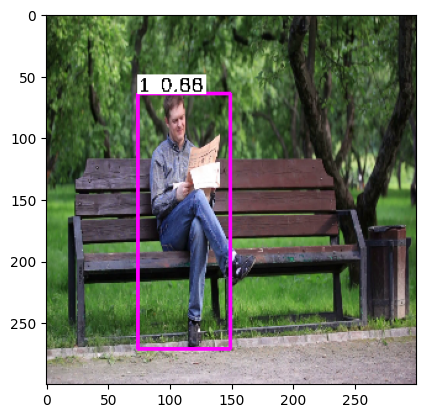

In [36]:

# get files from folder 
types = ('*.jpg', '*.png')  
files = []
for fmask in types:
    files.extend(glob.glob("./test_images/"+fmask))
 

for file in files:
    origin_img = cv2.imread(file, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(origin_img, cv2.COLOR_BGR2RGB)
    img = detect(model, img, min_score=0.4)

    plt.imshow(img)
    plt.show()

## Test (test dataloader)

/tmp/ipykernel_94653/3767907929.py:266: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  image_boxes.append(class_decoded_locs[1 - suppress])
/tmp/ipykernel_94653/3767907929.py:268: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  image_scores.append(class_scores[1 - suppress])


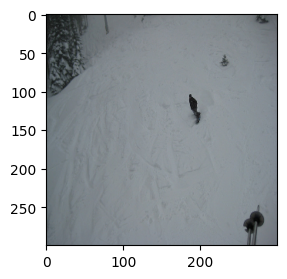

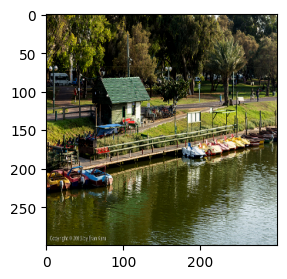

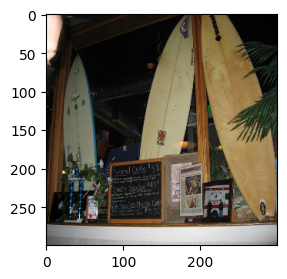

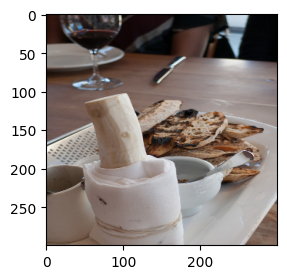

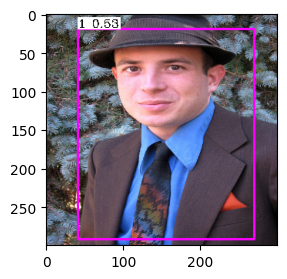

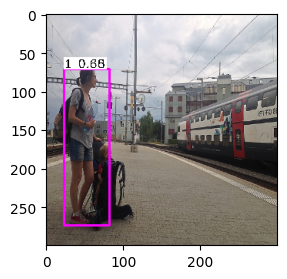

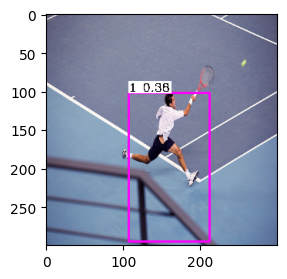

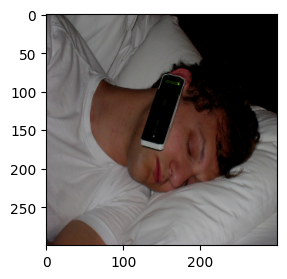

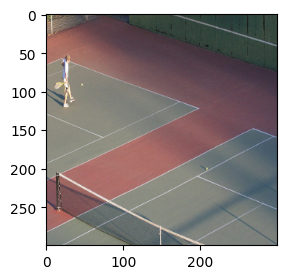

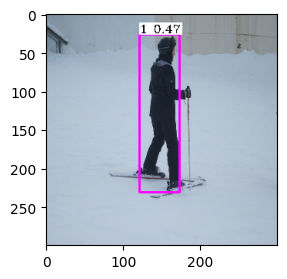

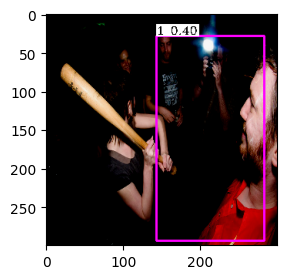

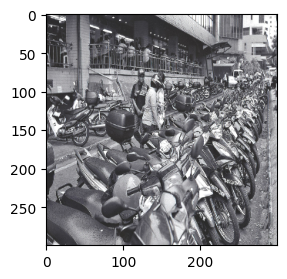

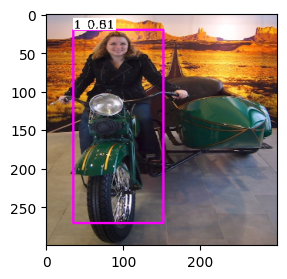

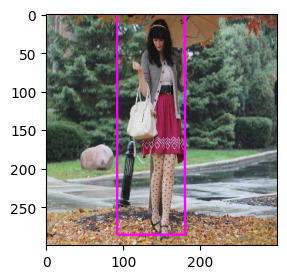

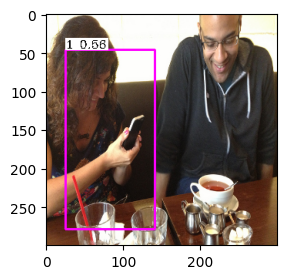

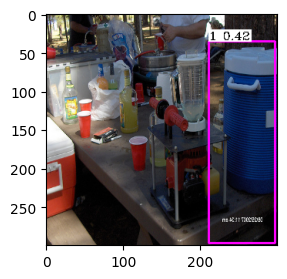

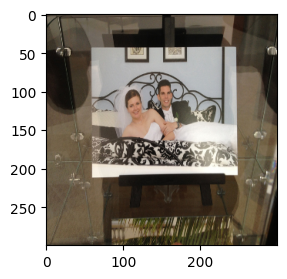

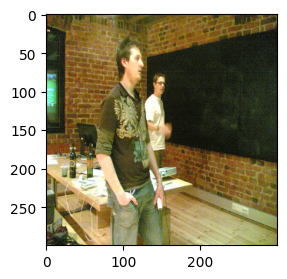

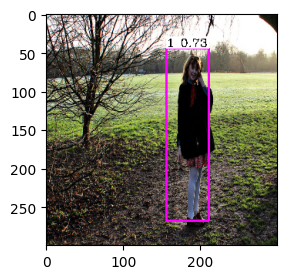

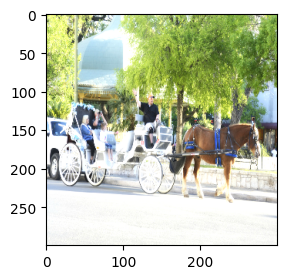

In [50]:
def test(n=5):
    d = []
 
    for batch in test_loader:
        b_size = batch[0].shape[0]
        for i in range(b_size):
            
            image = batch[0][i].permute(1,2,0).numpy()
            image = detect(model, image, min_score=0.35, max_overlap=0.5)
         
            d.append(image)
            if len(d)==n:
                return d
    return d
    
for i in test(20):
    plt.figure(figsize=(3, 3))
    plt.imshow(i)